In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install rouge

import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from rouge import Rouge
import pandas as pd
from sklearn.model_selection import train_test_split

# Preprocessing

In [3]:


# Load the BBC News Summary dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/bbc-news-summary.csv')

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

# Optionally, you can reset the index for both sets
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [4]:
train_data = train_data.drop(['File_path'], axis=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.drop(['File_path'], axis=1)
test_data = test_data.reset_index(drop=True)

In [5]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [6]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)

    return text

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in train_data.Summaries:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')

clean_texts = []
for text in train_data.Articles:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')
del train_data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cleaning Summaries Complete
Cleaning Texts Complete


In [8]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:110000]
clean_df['summary'] = clean_summaries[:110000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
del clean_texts
del clean_summaries

# Tokenizing Text And Summary Data

In [9]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)
del clean_df

In [10]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [11]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  59.073145553753136
Total Coverage of rare words:  6.016302428689135
Text Vocab:  11101


In [12]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [13]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  72.16036826892196
Total Coverage of rare words:  7.951277543768715
Summary Vocab:  5201


In [14]:
maxlen_text = 800
maxlen_summ = 150

In [15]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [16]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [17]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (1800, 800)
Target Values Shape (1800, 150)
Test Sequence (201, 800)
Target Test Shape (201, 150)


# Pretrained Embedding

In [19]:
embeding_index = {}
embed_dim = 100
with open('/content/drive/MyDrive/Datasets/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [20]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [21]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [22]:
del embeding_index

# Model Architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 800)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 800, 100)             1110100   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 256),                234496    ['embedding[0][0]']           
 al)                          (None, 128),                                                    

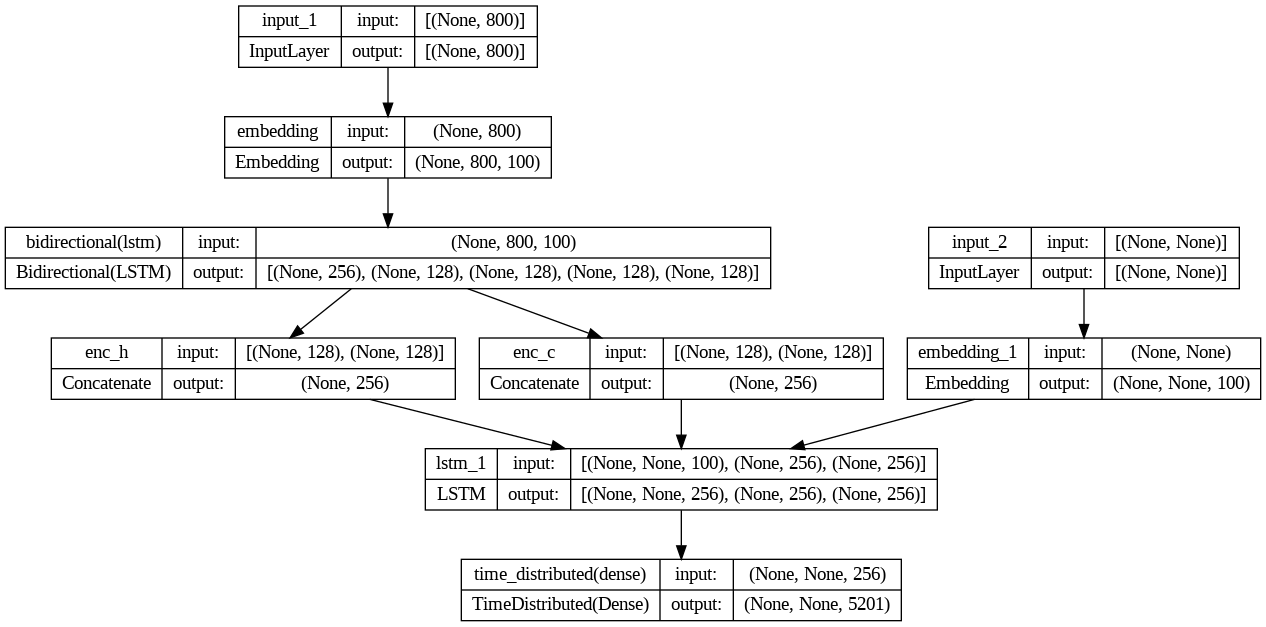

In [23]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
# h_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# h_out, _, _ = h_lstm(enc_embed)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='./seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [24]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
lstm = model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=50, callbacks=[early_stop], batch_size=128, verbose=2, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/50
15/15 - 25s - loss: 7.6256 - accuracy: 0.0856 - val_loss: 6.2687 - val_accuracy: 0.0558 - 25s/epoch - 2s/step
Epoch 2/50
15/15 - 9s - loss: 6.0972 - accuracy: 0.1612 - val_loss: 5.9793 - val_accuracy: 0.1571 - 9s/epoch - 621ms/step
Epoch 3/50
15/15 - 11s - loss: 5.8898 - accuracy: 0.1748 - val_loss: 5.8235 - val_accuracy: 0.1863 - 11s/epoch - 753ms/step
Epoch 4/50
15/15 - 8s - loss: 5.7658 - accuracy: 0.1987 - val_loss: 5.7339 - val_accuracy: 0.1900 - 8s/epoch - 533ms/step
Epoch 5/50
15/15 - 9s - loss: 5.6857 - accuracy: 0.2031 - val_loss: 5.6765 - val_accuracy: 0.2085 - 9s/epoch - 621ms/step
Epoch 6/50
15/15 - 9s - loss: 5.6328 - accuracy: 0.2141 - val_loss: 5.6378 - val_accuracy: 0.2110 - 9s/epoch - 609ms/step
Epoch 7/50
15/15 - 8s - loss: 5.5958 - accuracy: 0.2186 - val_loss: 5.6049 - val_accuracy: 0.2108 - 8s/epoch - 540ms/step
Epoch 8/50
15/15 - 9s - loss: 5.5638 - accuracy: 0.2189 - val_loss: 5.5761 - val_accuracy: 0.2107 - 9s/epoch - 619ms/step
Epoch 9/50
15/15 - 10s 

# Inference

In [25]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [26]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq

In [27]:
test_inputs = [clean_text(sent) for sent in test_data.Articles]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [28]:
hyps = []
with open('./result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(50):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.Articles[i], test_data.Summaries[i], our_summ])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step


# ROUGE score

In [29]:
rouge = Rouge()
rouge.get_scores(hyps, test_data.Summaries, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.04452759906893213,
  'p': 0.45303108003108006,
  'f': 0.07971592583186726},
 'rouge-2': {'r': 0.008387774902109388,
  'p': 0.07737498656800045,
  'f': 0.014731733004190587},
 'rouge-l': {'r': 0.04281319434255959,
  'p': 0.4366592851592852,
  'f': 0.07664516881518113}}

In [30]:
import numpy as np
import pandas as pd
from sklearn import datasets

keys = ['business','entertainment','politics','sport','tech']
dataset = {}
for key in keys:
    df = pd.read_pickle("/content/drive/MyDrive/Datasets/train_df_label_"+key+".pickle" )
    df_result = df[['Text', 'Summary', 'text_clean', "summary_clean", "labels", "labels_idx_list"]].copy()
    dataset[key] = df_result[:360]

dataset["business"].tail()

,Text,Summary,text_clean,summary_clean,labels,labels_idx_list
355,South Korea will boost state spending next ye...,"""The focus will be on job creation and economi...",[ South Korea will boost state spending next y...,"[""The focus will be on job creation and econom...","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...","[0, 4, 5, 7, 12, 15, 16, 19]"
356,"The Open Society Institute (OSI), financed by...","The Open Society Institute (OSI), financed by ...","[ The Open Society Institute (OSI), financed b...","[The Open Society Institute (OSI), financed by...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...","[0, 2, 4, 6, 8, 9]"
357,German investment bank Deutsche Bank has chal...,Deutsche Bank contends Yukos filed for bankrup...,[ German investment bank Deutsche Bank has cha...,[Deutsche Bank contends Yukos filed for bankru...,"[1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 2, 5, 9, 13, 14, 15]"
358,Fiat will meet car giant General Motors (GM) ...,Fiat claims that GM is legally obliged to buy ...,[ Fiat will meet car giant General Motors (GM)...,[Fiat claims that GM is legally obliged to buy...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[1, 8, 9, 13]"
359,Chile's copper industry has registered record...,Chile's copper industry has registered record ...,[ Chile's copper industry has registered recor...,[Chile's copper industry has registered record...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 7, 10]"


In [31]:
df_all_doc = pd.read_pickle("/content/drive/MyDrive/Datasets/train_df_not_shuffle.pickle" )
df_all_doc.tail()

,Text,Category,text_clean
2220,Top-seeded Americans Andy Roddick and Andre A...,sport,[ Top-seeded Americans Andy Roddick and Andre ...
2221,Unseeded Nicolas Almagro became the fifth Spa...,sport,[ Unseeded Nicolas Almagro became the fifth Sp...
2222,Second seed Andre Agassi suffered a comprehen...,sport,[ Second seed Andre Agassi suffered a comprehe...
2223,Teenager Sania Mirza completed a superb week ...,sport,[ Teenager Sania Mirza completed a superb week...
2224,Andy Roddick will play Cyril Saulnier in the ...,sport,[ Andy Roddick will play Cyril Saulnier in the...


In [32]:
X_all_doc = df_all_doc["Text"]
X_all_doc = np.array(X_all_doc)
len(X_all_doc)

2225

In [33]:
import tensorflow as tf
import keras
text_vectorizer = keras.layers.TextVectorization(max_tokens=34500, standardize="lower_and_strip_punctuation",
                                                 split="whitespace", output_mode="int", output_sequence_length=500)

text_vectorizer.adapt(X_all_doc, batch_size=2225)

vocab = text_vectorizer.get_vocabulary()
print("Vocab : {}".format(vocab[:10]))
print("Vocab Size : {}".format(text_vectorizer.vocabulary_size()))


Vocab : ['', '[UNK]', 'the', 'to', 'of', 'and', 'a', 'in', 'for', 'is']
Vocab Size : 34422


In [34]:
out = text_vectorizer(X_all_doc[:1])
print(type(out))
print(len(X_all_doc[:1][0].split(" ")))
print("Output Shape : {}".format(out.shape))
print(np.array(out)[0][41])

<class 'tensorflow.python.framework.ops.EagerTensor'>
412
Output Shape : (1, 500)
583


In [35]:
keys = ['business','entertainment','politics','sport','tech']
#key_idx = {'business': 1,'entertainment': 2,'politics': 3,'sport': 4,'tech': 5}
for key in keys:
    df_category = dataset[key]
    vectorized_text_list = []
    for i in range(len(df_category)):
        vectorized_text = text_vectorizer(df_category.iloc[i]["text_clean"])
        vectorized_text = np.array(vectorized_text)

        vectorized_text_list.append(vectorized_text)
    df_category["text_embedding"] = vectorized_text_list

dataset["sport"].head()

<ipython-input-35-b4c3b787d302>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_category["text_embedding"] = vectorized_text_list


,Text,Summary,text_clean,summary_clean,labels,labels_idx_list,text_embedding
0,British hurdler Sarah Claxton is confident sh...,"For the first time, Claxton has only been prep...",[ British hurdler Sarah Claxton is confident s...,"[For the first time, Claxton has only been pre...","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0, 2, 6, 9, 11]","[[157, 12262, 4798, 6860, 9, 1118, 74, 57, 141..."
1,Sonia O'Sullivan has indicated that she would...,"The participation of O'Sullivan, currentily tr...",[ Sonia O'Sullivan has indicated that she woul...,"[The participation of O'Sullivan, currentily t...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]","[3, 4, 6]","[[9054, 3111, 19, 2819, 10, 74, 38, 93, 3, 773..."
2,Maurice Greene aims to wipe out the pain of l...,I think when I was coming up I would say there...,[ Maurice Greene aims to wipe out the pain of ...,[I think when I was coming up I would say ther...,"[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0, 3, 3, 3, 4, 8, 9, 10, 11, 13, 14, 21, 21]","[[6277, 5361, 2284, 3, 6955, 56, 2, 4833, 4, 1..."
3,The IAAF - athletics' world governing body - ...,"""I am very happy to see you all, members of th...",[ The IAAF - athletics' world governing body -...,"[""I am very happy to see you all, members of t...","[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[0, 3, 6, 8]","[[2, 1902, 1595, 77, 3128, 951, 19, 997, 3914,..."
4,Ethiopia's Tirunesh Dibaba set a new world re...,Ethiopia's Tirunesh Dibaba set a new world rec...,[ Ethiopia's Tirunesh Dibaba set a new world r...,[Ethiopia's Tirunesh Dibaba set a new world re...,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0, 1, 3, 6]","[[14852, 13365, 10832, 115, 6, 47, 77, 220, 7,..."


In [36]:
len(dataset["sport"].iloc[0]["text_embedding"][0])


500

In [37]:
from sklearn.model_selection import train_test_split
train_sport, test_sport = train_test_split(dataset["sport"], test_size=0.1)
train_business, test_business = train_test_split(dataset["business"], test_size=0.1)
train_entertainment, test_entertainment = train_test_split(dataset["entertainment"], test_size=0.1)
train_tech, test_tech = train_test_split(dataset["tech"], test_size=0.1)
train_politics, test_politics = train_test_split(dataset["politics"], test_size=0.1)

train_test_sets = {}
train_test_sets["sport"] = {"train": train_sport, "test": test_sport}
train_test_sets["business"] = {"train": train_business, "test": test_business}
train_test_sets["entertainment"] = {"train": train_entertainment, "test": test_entertainment}
train_test_sets["tech"] = {"train": train_tech, "test": test_tech}
train_test_sets["politics"] = {"train": train_politics, "test": test_politics}

In [38]:
len(train_test_sets["sport"]["test"])

36

In [39]:
import pickle
test_data_file = 'test_data.pickle'
with open(test_data_file, 'wb') as handle:
    pickle.dump(train_test_sets, handle)

In [40]:
!pip install rouge-score
import numpy as np
import pandas as pd


import re
import string
import csv
import os
from keras.models import Sequential
import torch
from tensorflow.keras import optimizers, utils
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding,Dropout, Concatenate, TimeDistributed, Bidirectional, GRU, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from rouge_score import rouge_scorer
from tensorflow.keras import backend as K

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=a08cbf13c6fee024f1716cfa1ac039015909219ddbf81dc0586302192722fa15
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [41]:
from rouge_score import rouge_scorer
def calc_rouge_scores(pred_summaries, gold_summaries,
                                 keys=['rouge1', 'rougeL'], use_stemmer=True):
    #Calculate rouge scores
    scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer)

    n = len(pred_summaries)

    scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for
              j in range(n)]

    dict_scores={}
    for key in keys:
        dict_scores.update({key: {}})


    for key in keys:

        precision_list = [scores[j][key][0] for j in range(len(scores))]
        recall_list = [scores[j][key][1] for j in range(len(scores))]
        f1_list = [scores[j][key][2] for j in range(len(scores))]

        precision = np.mean(precision_list)
        recall = np.mean(recall_list)
        f1 = np.mean(f1_list)

        dict_results = {'recall': recall, 'precision': precision, 'f1': f1}

        dict_scores[key] = dict_results

    return dict_scores

In [42]:
def padding_sentence(X, Y):
    max_number_sentence = 246
    padding_X=np.empty(500)
    padding_X.fill(0)
    #print(len(X[0]))
    #print(Y[0])
    for i in range(len(X)):
        while(len(X[i]) < max_number_sentence):
            X[i] = np.append(X[i], [padding_X], axis = 0)
            Y[i] = np.append(Y[i], [0], axis = 0)

    return X, Y

In [43]:
def get_batch(tasks_key, batch_size, number_of_shot = None):
    batch_sets = {}
    test_sets = {}
    for key in tasks_key:

        if number_of_shot:
            X_train = np.array(train_test_sets[key]["train"]["text_embedding"])[:number_of_shot]
            y_train = np.array(train_test_sets[key]["train"]["labels"])[:number_of_shot]
        else:
            X_train = np.array(train_test_sets[key]["train"]["text_embedding"])
            y_train = np.array(train_test_sets[key]["train"]["labels"])

        X_test = np.array(train_test_sets[key]["test"]["text_embedding"])
        y_test = np.array(train_test_sets[key]["test"]["labels"])

        X_train, y_train = padding_sentence(X_train, y_train)
        X_test, y_test = padding_sentence(X_test, y_test)




        num_batches = (len(X_train) + batch_size - 1) // batch_size

        batches = []
        for i in range(num_batches):
            if batch_size*i+batch_size <= len(X_train):
                batches.append({"X_train": X_train[i*batch_size:i*batch_size+batch_size],
                                "y_train": y_train[i*batch_size:i*batch_size+batch_size]})
            else:
                batches.append({"X_train": X_train[i*batch_size:],
                                "y_train": y_train[i*batch_size:]})


        batch_sets[key]=batches
        test_sets[key] = {"X_test": X_test,
                                "y_test": y_test}


    return batch_sets, test_sets

In [44]:
from tensorflow.keras import layers, models, losses
import tensorflow as tf
import numpy as np


class MAML:
    def __init__(self):
        self.meta_model = self.get_maml_model()

    def get_maml_model(self):
        # define LSTM
        model = Sequential()



        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(246, 500)))


        model.add(Dense(1,activation='sigmoid'))
        #model.add(tf.keras.layers.Lambda(lambda pred_sentences: tf.squeeze(pred_sentences)))
        model.add(tf.keras.layers.Reshape((-1,), input_shape=(246,1)))
        return model

    def train_on_batch(self, support_train_data, query_train_data, inner_optimizer, outer_optimizer=None):

        batch_acc = []
        batch_loss = []
        task_weights = []

        support_task_key = ["tech","politics","entertainment","sport"]
        query_task_keys = ["business"]


        meta_weights = self.meta_model.get_weights()



        for key in support_task_key:

            self.meta_model.set_weights(meta_weights)

            X = np.array([np.array(val) for val in support_train_data[key]["X_train"]])
            y = np.array([np.array(val) for val in support_train_data[key]["y_train"]])
            with tf.GradientTape() as tape:
                pred = self.meta_model(X)
                loss = losses.binary_crossentropy(y, pred)

            # Calculate the gradients for the variables
            gradients = tape.gradient(loss, self.meta_model.trainable_variables)
            # Apply the gradients and update the optimizer
            inner_optimizer.apply_gradients(zip(gradients, self.meta_model.trainable_variables))


            task_weights.append(self.meta_model.get_weights())


        with tf.GradientTape() as tape:
            for i in range(len(support_task_key)):

                query_task_key = query_task_keys[0]

                self.meta_model.set_weights(task_weights[i])

                X = np.array([np.array(val) for val in query_train_data[query_task_key]["X_train"]])
                y = np.array([np.array(val) for val in query_train_data[query_task_key]["y_train"]])
                #print(len(X))
                pred = self.meta_model(X)
                loss = losses.binary_crossentropy(y, pred)

                batch_loss.append(loss)


            sum_loss = tf.reduce_sum(batch_loss)
            mean_loss = tf.reduce_mean(batch_loss)


        self.meta_model.set_weights(meta_weights)


        if outer_optimizer:
            grads = tape.gradient(sum_loss, self.meta_model.trainable_variables)
            outer_optimizer.apply_gradients(zip(grads, self.meta_model.trainable_variables))

        return mean_loss




In [45]:
import math

support_tasks_key = ["sport", "entertainment", "tech", "politics"]
query_tasks_key = ["business"]

number_of_shot = 6
query_batch_size = 1

support_batch_size = 60



support_batch_sets, support_test_sets = get_batch(support_tasks_key, support_batch_size)
query_batch_sets, query_test_sets = get_batch(query_tasks_key, query_batch_size, number_of_shot)

In [46]:
len(support_batch_sets["sport"])

6

In [47]:
len(query_batch_sets["business"])

6

In [48]:

def val_on_batch(model):
    # evaluate LSTM
    y_pred_list =[]
    idx_list=[]

    key_query_task="business"

    X_test = np.array([np.array(val) for val in query_test_sets[key_query_task]["X_test"]])

    y_preds = model.predict(X_test, verbose=0)

    print(len(y_preds))

    for j in range(len(y_preds)):
        idx = []
        for i in range(len(y_preds[j])):
            pred_percent = y_preds[j][i]
            if(pred_percent > 0.5):
                idx.append(i)
        if len(idx) < 5.0:
            idx = np.argsort(y_preds[j][-5:])
        idx = sorted(idx)
        idx_list.append(idx)

    val_sets = train_test_sets[key_query_task]["test"]

    #retrieve summary pairs
    df_text_clean = val_sets["text_clean"]
    pred_summaries = []
    for doc in range(len(idx_list)):
        pred_summary_sentences_list = []
        text_clean = np.array(df_text_clean.iloc[doc])
        idx_doc = idx_list[doc]
        for i in range(len(text_clean)):
            if(i in idx_doc):
                sentence = text_clean[i]
                pred_summary_sentences_list.append(sentence)

        pred_summary = " ".join(pred_summary_sentences_list)
        pred_summaries.append(pred_summary)


    df_gold = val_sets["Summary"]

    gold_summaries = [df_gold.iloc[m] for m in range(len(df_gold))]




    summaries_comp = tuple(zip(pred_summaries, gold_summaries))


    #calculate rouge score
    scores = calc_rouge_scores(pred_summaries, gold_summaries,
                                  keys=['rouge1', 'rougeL'], use_stemmer=True)

    return scores


In [49]:
epochs = 50


maml = MAML()

inner_optimizer = optimizers.Adam(learning_rate=0.001)
outer_optimizer = optimizers.Adam(learning_rate=0.001)

#print(y_test)

query_key = "business"

training_steps = 1000
for key in support_batch_sets:
    if(len(support_batch_sets[key]) < training_steps):
        training_steps = len(support_batch_sets[key])

for key in query_batch_sets:
    if(len(query_batch_sets[key]) < training_steps):
        training_steps = len(query_batch_sets[key])


valuating_steps = len(query_test_sets[query_key]["X_test"])


train_progbar = utils.Progbar(training_steps)

loss_plot = []
f1_score_plot = []
precision_plot = []
recall_plot = []
print(support_batch_sets["sport"][0]["X_train"].shape)
#print(batch_sets["sport"][0]["y_train"])
#print(batch_sets["sport"][0]["y_train"].shape)
#print(type(batch_sets["sport"][0]["y_train"]))
#x_train = np.array([np.array(val) for val in batch_sets["sport"][0]["X_train"]])
#print(x_train.shape)
#y_train = np.array([np.array(val) for val in batch_sets["sport"][0]["y_train"]])
#pred = maml.meta_model(x_train)
#print(pred.shape)
#loss = losses.binary_crossentropy(y_train, pred)
#print(loss)

for epoch in range(epochs):
    train_meta_loss = []
    val_meta_loss = []

    for i in range(training_steps):
        support_train_data = {}
        query_train_data = {}

        for support_key in support_batch_sets:
            support_train_data[support_key] = support_batch_sets[support_key][i]
        for query_key in query_batch_sets:
            query_train_data[query_key] = query_batch_sets[query_key][i]

        batch_train_loss = maml.train_on_batch(support_train_data,
                                                        query_train_data,
                                                        inner_optimizer,
                                                        outer_optimizer=outer_optimizer)

        train_meta_loss.append(batch_train_loss)
        train_progbar.update(i+1, [('loss', np.mean(train_meta_loss))])

    loss_plot.append( np.mean(train_meta_loss))

    scores = val_on_batch(maml.meta_model)
    f1_score_plot.append(scores["rouge1"]["f1"])
    precision_plot.append(scores["rouge1"]["precision"])
    recall_plot.append(scores["rouge1"]["recall"])

    print("\n")
    print(scores)
    print("\n")





maml.meta_model.save("/content/drive/MyDrive/ModelData.h5")


(60,)


6/6 [==============================] - 10s 1s/step - loss: 0.6630
36


{'rouge1': {'recall': 0.609210275225228, 'precision': 0.6851507028285011, 'f1': 0.6314053430263414}, 'rougeL': {'recall': 0.3918618544315044, 'precision': 0.44022863009766455, 'f1': 0.40605523165525403}}


6/6 [==============================] - 24s 2s/step - loss: 0.4193
36


{'rouge1': {'recall': 0.6559139264821735, 'precision': 0.5490966115794732, 'f1': 0.5894278706845498}, 'rougeL': {'recall': 0.44175415766297726, 'precision': 0.36680909433377257, 'f1': 0.3952188134902743}}


6/6 [==============================] - 37s 2s/step - loss: 0.3005
36


{'rouge1': {'recall': 0.6472120913130628, 'precision': 0.5250891273692573, 'f1': 0.567538249071804}, 'rougeL': {'recall': 0.4431107932744693, 'precision': 0.35958378538855684, 'f1': 0.388997751195186}}


6/6 [==============================] - 44s 834ms/step - loss: 0.2401
36


{'rouge1': {'recall': 0.6653977567808927, 'precision': 0.50391231466456, 'f1': 0.560143913422454

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




{'rouge1': {'recall': 0.6525215214627074, 'precision': 0.5527839610778407, 'f1': 0.5870097755127591}, 'rougeL': {'recall': 0.4679051114916194, 'precision': 0.3925638400387944, 'f1': 0.41873269061026336}}




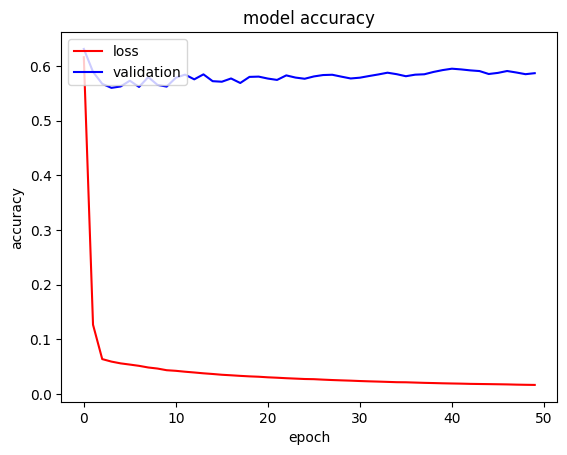

In [50]:

from matplotlib import pyplot as plt

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

epochs_plot = [i for i in range(epochs)]


plt.plot(epochs_plot, loss_plot , color="red", label = "loss")
plt.plot(epochs_plot, f1_score_plot, color="blue", label = "validation")

plt.legend(loc='upper left')

plt.show()


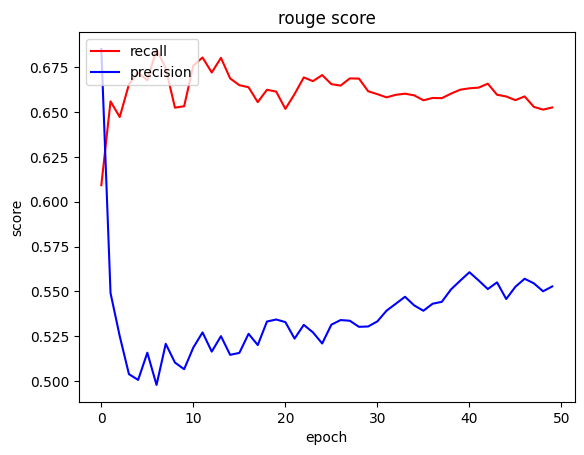

In [51]:
plt.title('rouge score')
plt.ylabel('score')
plt.xlabel('epoch')

epochs_plot = [i for i in range(epochs)]

plt.plot(epochs_plot, recall_plot, color="red", label = "recall")
plt.plot(epochs_plot, precision_plot, color="blue", label = "precision")

plt.legend(loc='upper left')

plt.show()


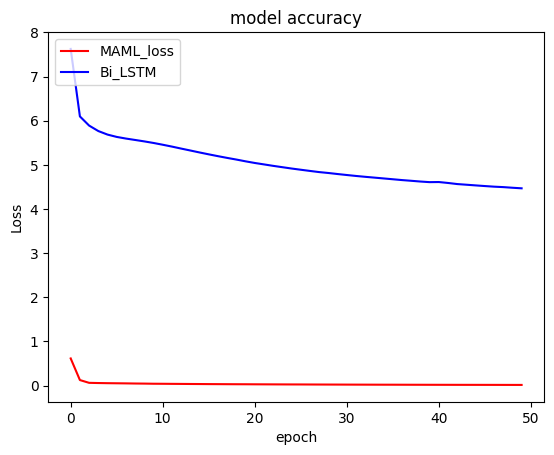

In [55]:
plt.title('model accuracy')
plt.ylabel('Loss')
plt.xlabel('epoch')

epochs_plot = [i for i in range(epochs)]


plt.plot(epochs_plot, loss_plot , color="red", label = "MAML_loss")
plt.plot(epochs_plot, lstm.history['loss'], color="blue", label = "Bi_LSTM")

plt.legend(loc='upper left')

plt.show()

In [56]:
output_file = '/content/drive/MyDrive/ModelData/result.pickle'


y_pred_list =[]
idx_list=[]

key_query_task="business"

X_test = np.array([np.array(val) for val in query_test_sets[key_query_task]["X_test"]])


y_preds = maml.meta_model.predict(X_test, verbose=0)



for j in range(len(y_preds)):
    idx = []
    for i in range(len(y_preds[j])):
        pred_percent = y_preds[j][i]
        if(pred_percent > 0.5):
            idx.append(i)
    if len(idx) < 5.0:
        idx = np.argsort(y_preds[j][-5:])
    idx = sorted(idx)
    idx_list.append(idx)

val_sets = train_test_sets[key_query_task]["test"]

#retrieve summary pairs
df_text_clean = val_sets["text_clean"]
pred_summaries = []
for doc in range(len(idx_list)):
    pred_summary_sentences_list = []
    text_clean = np.array(df_text_clean.iloc[doc])
    idx_doc = idx_list[doc]
    for i in range(len(text_clean)):
        if(i in idx_doc):
            sentence = text_clean[i]
            pred_summary_sentences_list.append(sentence)

    pred_summary = " ".join(pred_summary_sentences_list)
    pred_summaries.append(pred_summary)


df_gold = val_sets["Summary"]

gold_summaries = [df_gold.iloc[m] for m in range(len(df_gold))]




summaries_comp = tuple(zip(pred_summaries, gold_summaries))


#calculate rouge score
scores = calc_rouge_scores(pred_summaries, gold_summaries,
                                  keys=['rouge1', 'rougeL'], use_stemmer=True)

results_dict ={'summaries_comp': summaries_comp,
               'sent_index_number': idx, 'Rouge': scores, 'mod_summary': maml.meta_model.summary()}

with open(output_file, 'wb') as handle:
    pickle.dump(results_dict, handle)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 246, 256)          644096    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 246, 1)            257       
                                                                 
 reshape (Reshape)           (None, 246)               0         
                                                                 
Total params: 644353 (2.46 MB)
Trainable params: 644353 (2.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [57]:
result = pd.read_pickle("/content/drive/MyDrive/ModelData/result.pickle")
print(result["Rouge"])
print("\nPrediction\n")
print(result["summaries_comp"][0][0])
print("\nReal summary\n")
print(result["summaries_comp"][0][1])

{'rouge1': {'recall': 0.6525215214627074, 'precision': 0.5527839610778407, 'f1': 0.5870097755127591}, 'rougeL': {'recall': 0.4679051114916194, 'precision': 0.3925638400387944, 'f1': 0.41873269061026336}}

Prediction

 The US Justice Department is to try to overturn a court ruling that threw out its claim for $280bn (£149bn) in damages from tobacco firms. 

Earlier this month, a three-judge appeal court panel rejected the claim - filed in 1999 by the administration of Bill Clinton - in a 2-1 decision. Government lawyers said they would ask the full US Court of Appeals for the District of Columbia to hear the case. The court room battle is seen as key in government attempts to fight smoking. "It's pretty clear that they've suffered a severe setback," said Anthony Sebok, a professor at Brooklyn Law School, adding that the appeal was what the government "would be expected to ask for".

Real summary

Government lawyers said they would ask the full US Court of Appeals for the District of Col